In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers.optimization import get_constant_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
print("DONE!!!")

DONE!!!


In [2]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.0 MB/s eta 0:00:00


In [3]:
print("Datasets......\n1. SNLI \n2. MULTI-NLI\n3. SICK")
for i in range(3):
    dataset_choice = int(input("Enter choice :"))
    if dataset_choice == 1:
        dataset = load_dataset("snli")
        break
    elif dataset_choice == 2:
        dataset = load_dataset("multi_nli")
        break
    elif dataset_choice == 3:
        dataset =  load_dataset("sick")
        break
else:
    print("Invalid Choices Thrice....\nRun the program again")
    exit()

Datasets......
1. SNLI 
2. MULTI-NLI
3. SICK


Enter choice : 2


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [4]:
class NLIDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'premise': item['premise'],
            'hypothesis': item['hypothesis'],
            'label': item['label']
        }

print("DONE!!!")

DONE!!!


In [5]:
print(dataset_choice, end = "-")

if dataset_choice == 1:
    print("SNLI")
    dataset['train'] = dataset['train'].filter(lambda sen: sen['label'] != -1)
    dataset['validation'] = dataset['validation'].filter(lambda sen: sen['label'] != -1)
    dataset['test'] = dataset['test'].filter(lambda sen: sen['label'] != -1)
    train_data = dataset['train']
    test_data = dataset['test']
    validation_data = dataset['validation']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 2:
    print("MULTI-NLI")
    train_data = dataset['train']
    validation_data = dataset['validation_matched']
    test_data = dataset['validation_mismatched']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),  
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)),  
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 3:
    print("SICK")
    train_data = dataset['train']
    validation_data = dataset['validation']
    test_data = dataset['test']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['sentence_A'],
        'hypothesis': train_data['sentence_B'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['sentence_A'],
        'hypothesis': validation_data['sentence_B'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['sentence_A'],
        'hypothesis': test_data['sentence_B'],
        'label': test_data['label']
    })

print("DONE!!!")

2-MULTI-NLI
DONE!!!


In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
optimizer = AdamW(model.parameters(), lr=1e-5)

print(dataset_choice)
# Datasets......
train_ds = NLIDataset(train_dataset)
val_ds = NLIDataset(val_dataset)
test_ds = NLIDataset(test_dataset)

# DataLoaders......
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))
print("DONE!!!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2
12272 307 308
DONE!!!


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r = 1,
                        lora_alpha = 32,
                        lora_dropout = 0.01,
                        target_modules=['query', 'key', 'value'])

In [8]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=1, target_modules={'query', 'value', 'key'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [9]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 57,603 || all params: 109,542,150 || trainable%: 0.05258523773725456


In [10]:
# from transformers import (
#     AutoTokenizer,
#     AutoConfig,
#     AutoModelForSequenceClassification,
#     DataCollatorWithPadding,
#     TrainingArguments,
#     Trainer)

In [11]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

model = get_peft_model(base_model, peft_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

all_preds = []
epochs = 3
for epoch in range(epochs):
    print(epoch + 1, "Epoch.......")

    # Training.....
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)

    # Validation....
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    # Testingggg.....
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    all_preds.append(test_preds)
    print("Test Accuracy:", test_accuracy)
    print()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1 Epoch.......


Epoch 1 Training: 100%|██████████| 12272/12272 [44:31<00:00,  4.59it/s] 


Train Accuracy: 0.7781600297426547


Validation: 100%|██████████| 307/307 [00:33<00:00,  9.06it/s]


Validation Accuracy: 0.8202750891492613


Testing: 100%|██████████| 308/308 [00:35<00:00,  8.72it/s]


Test Accuracy: 0.8254678600488202

2 Epoch.......


Epoch 2 Training: 100%|██████████| 12272/12272 [43:42<00:00,  4.68it/s] 


Train Accuracy: 0.8248340981202031


Validation: 100%|██████████| 307/307 [00:33<00:00,  9.09it/s]


Validation Accuracy: 0.8351502801833928


Testing: 100%|██████████| 308/308 [00:35<00:00,  8.75it/s]


Test Accuracy: 0.8361472742066721

3 Epoch.......


Epoch 3 Training: 100%|██████████| 12272/12272 [43:45<00:00,  4.67it/s] 


Train Accuracy: 0.8344291600246497


Validation: 100%|██████████| 307/307 [00:33<00:00,  9.07it/s]


Validation Accuracy: 0.8436067244014264


Testing: 100%|██████████| 308/308 [00:35<00:00,  8.70it/s]

Test Accuracy: 0.8379780309194467



Test Accuracy : 83.80%
F1 Score : 83.83%
Recall Score : 83.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3463
           1       0.78      0.81      0.80      3129
           2       0.87      0.84      0.85      3240

    accuracy                           0.84      9832
   macro avg       0.84      0.84      0.84      9832
weighted avg       0.84      0.84      0.84      9832



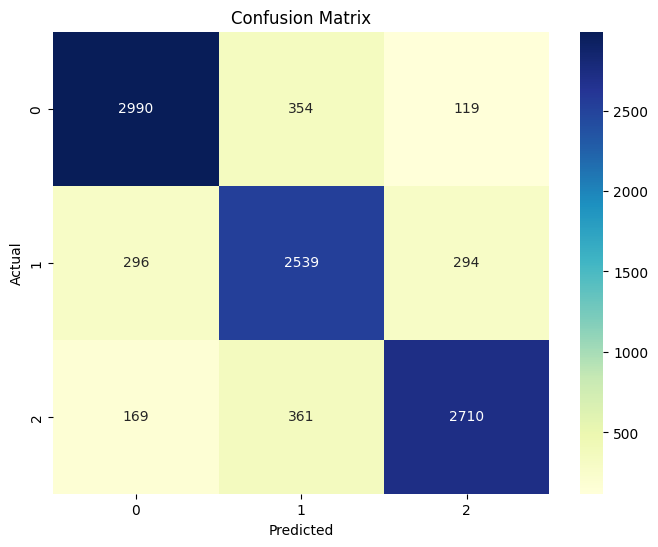

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import seaborn as sns


# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Recall Score : {:.2f}%".format(recall * 100))

# classification_report
class_report = classification_report(test_labels, test_preds)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()